# **Stat 6500 Excerise Set 3**
    Authored by Brian Lesko, a Graduate Researcher and Teaching Associate, a Masters of mechanical engineering student, studying mechatronic controls, robotics, and machine learning.

    This documenet is originally an interactive python notebook

    Contents: 
    
A. Topics from *An Introduction to Statistical Learning* Section 6.5.2

    1. predict major league baseball players’ salary using predictors in the Hitters data with ridge regression and lasso.
        (a) Examine the scatterplots of the response versus each of the predictors. If needed, consider transformations of the variables.

        (b) Split the data set into a training set and a test set of the same size.

        (c) Fit a ridge regression model on the training set for a range of λ values.
            i. Display the coefficient paths as a function of λ.
            ii. Perform cross validation to choose λ. 
            iii. Plot the test MSE and cross validation error as a function of λ. Comment on their relation.

        (d) Fit a lasso model on the training set for a range of λ values.
            i. Display the coefficient paths as a function of λ. Also, plot the number of non-zero coefficient estimates as a function of λ.
            ii. Perform cross validation to choose λ. Use the same data split as in ridge regression for cross validation.
            iii. Plot the test MSE and cross validation error as a function of λ. Comment on their relation. 

        (e) Comment on the results obtained in (c) and (d) by comparing the two approaches in terms of the test error.
        
    2. Suppose that the observed values xij on the predictors Xj , (j = 1, . . . , p) and the response values yi on Y have been centered to zero. Consider fitting the following regression model
        Y = β1 * X1 + ··· + βp * Xp +ε 
        to the centered data using ridge regression by minimizing
        RSS(B) = 
        n p !2 p RSSλ(β)=X yi −Xβjxij +λXβj2.
        i=1 j=1 j=1
        Verify that the optimality conditions for the ridge regression solution,
        ∂RSSλ(β) = 0 for j = 1,...,p, ∂βj
        lead to (X⊤X +λIp)β = X⊤y, where X is the n×p matrix with (xi1,··· ,xip) in the ith row and y = (y1, . . . , yn)⊤ is the response vector.

B. *Additional Exercises from Intructor Yookyung Lee* 

# 1) The Hitters Dataset, 
### Lasso and Ridge Regression for feature selection and correlated variables 

## Dataset & Background

*This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.*

In [257]:
# Import the hitters dataset from Kaggle
# From Kaggle: https://www.kaggle.com/datasets/floser/hitters
url = "https://gist.github.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv"

#define a function to read the data from the url and return a pandas dataframe while dropping NA values
def read_data(url):
    import pandas as pd
    df = pd.read_csv(url, na_values="?")
    df = df.dropna()
    return df

#call the function to read the data
df = read_data(url)


In [258]:
# Inspect the data

# define a function called inspect
def inspect(df):
    print(df.head(2))
    print(' The shape of the data is',df.shape)

#call the function to inspect the data
inspect(df)

     Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
1   -Alan Ashby    315    81      7    24   38     39     14    3449    835   
2  -Alvin Davis    479   130     18    66   72     76      3    1624    457   

   ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  Salary  \
1  ...    321   414     375       N        W     632       43      10   475.0   
2  ...    224   266     263       A        W     880       82      14   480.0   

   NewLeague  
1          N  
2          A  

[2 rows x 21 columns]
 The shape of the data is (263, 21)


In [259]:
#the data does not have a label for the player name in column 0, so change the name to player
df.rename(columns={'Unnamed: 0':'Player'}, inplace=True)

#check the data again
inspect(df)

         Player  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
1   -Alan Ashby    315    81      7    24   38     39     14    3449    835   
2  -Alvin Davis    479   130     18    66   72     76      3    1624    457   

   ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  Salary  \
1  ...    321   414     375       N        W     632       43      10   475.0   
2  ...    224   266     263       A        W     880       82      14   480.0   

   NewLeague  
1          N  
2          A  

[2 rows x 21 columns]
 The shape of the data is (263, 21)


In [260]:
#lets check the data types
#df.dtypes

# convert the league and division and NewLeague columns to an int64 0 or 1
df['League'] = df['League'].map({'A':0, 'N':1})
df['Division'] = df['Division'].map({'E':0, 'W':1})
df['NewLeague'] = df['NewLeague'].map({'A':0, 'N':1})
df.dtypes

Player        object
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League         int64
Division       int64
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague      int64
dtype: object

### Summary Statistics

In [261]:
# lets check the description of the data
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,0.471483,0.509506,290.711027,118.760456,8.593156,535.925882,0.463878
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,0.500138,0.500863,279.934575,145.080577,6.606574,451.118681,0.499644
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000,0.000000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,0.000000,0.000000,113.500000,8.000000,3.000000,190.000000,0.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,0.000000,1.000000,224.000000,45.000000,7.000000,425.000000,0.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,1.000000,1.000000,322.500000,192.000000,13.000000,750.000000,1.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1.000000,1.000000,1377.000000,492.000000,32.000000,2460.000000,1.000000


<AxesSubplot: >

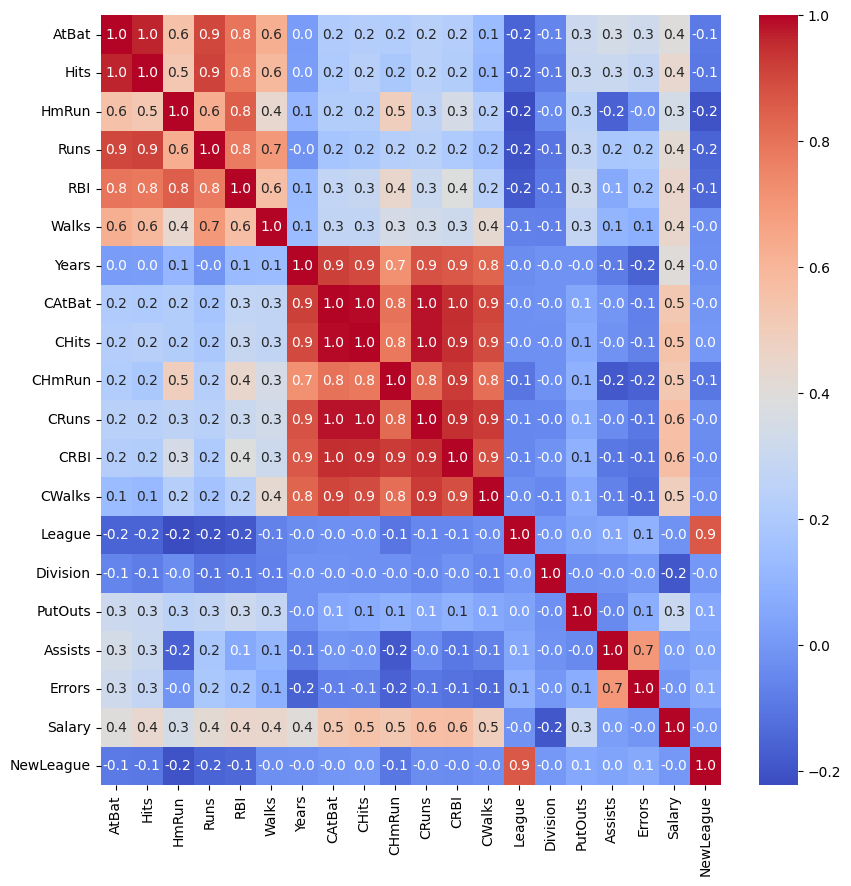

In [262]:
# plot the correlation matrix of the data with a heatmap in matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.1f', cmap='coolwarm')

as seen in the bottom row, Many of the predictors are weak-moderately linear with salary, but seem to have a large variance
Lets make scatterplots to investigate further

### a) Scatterplot of response vs predictors 

In [263]:
# there are 19 predictors and 1 response variable
# lets plot each predictor against the response variable to see the relationship

# create a vector of predictor names
predictors = df.columns[1:19]
# add the New League predictor to the vector
predictors = np.append(predictors, 'NewLeague')
print(predictors),print('')

# create a target variable for salart
y = df['Salary']
print(y.head(2))

['AtBat' 'Hits' 'HmRun' 'Runs' 'RBI' 'Walks' 'Years' 'CAtBat' 'CHits'
 'CHmRun' 'CRuns' 'CRBI' 'CWalks' 'League' 'Division' 'PutOuts' 'Assists'
 'Errors' 'NewLeague']

1    475.0
2    480.0
Name: Salary, dtype: float64


Text(0.5, 0.98, 'Linear Regression with Salary as the Response Variable')

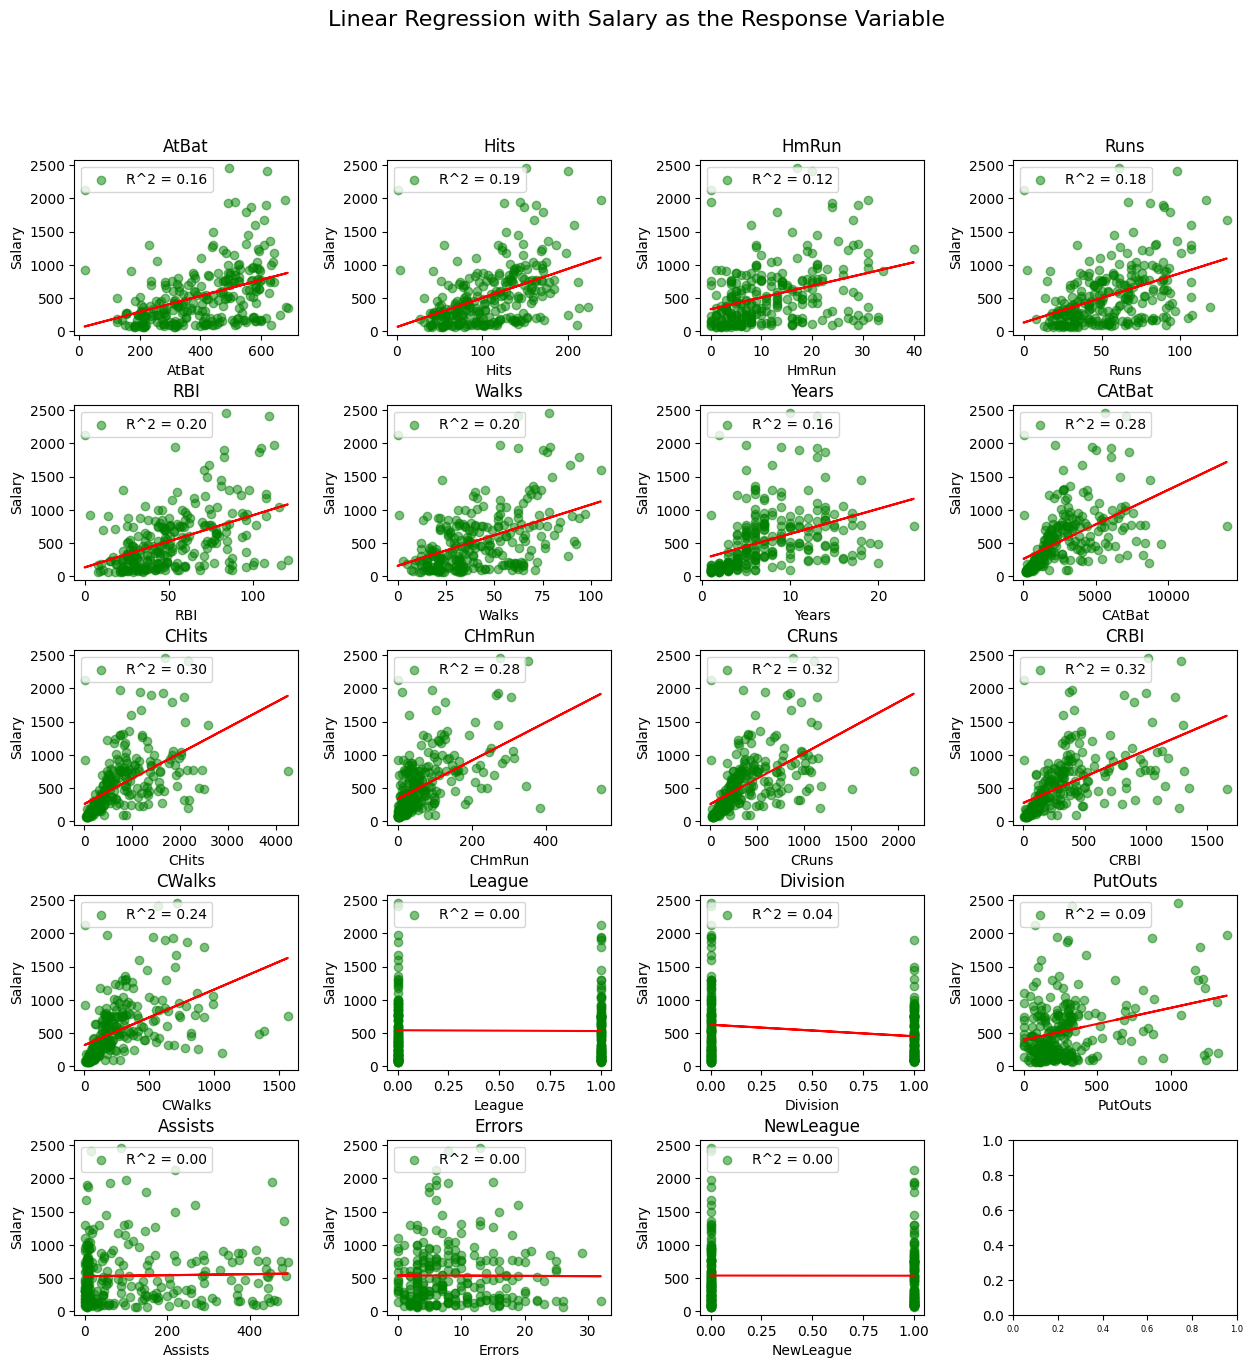

In [264]:
# create a wrapped set of axes for the subplots, 4 by 4
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,15))

from sklearn.linear_model import LinearRegression

# loop through the axes and plot the data
for i, ax in enumerate(axes.flatten()):
    if i < len(predictors):
        ax.scatter(df[predictors[i]], y, color='green', alpha=0.5)
        ax.set_xlabel(predictors[i])
        ax.set_ylabel('Salary')
        ax.set_title(predictors[i])

        # space out the axes
        plt.subplots_adjust(hspace=0.4)
        # space out horizontally 
        plt.subplots_adjust(wspace=0.4)
        # reduce the axes tick size
        plt.xticks(fontsize=6)

        #if the the predictor type is quantitaive, plot a least squares regression line using scikit-learn
        if df[predictors[i]].dtype == 'int64' or df[predictors[i]].dtype == 'float64':
            x = df[predictors[i]].values.reshape(-1,1)
            model = LinearRegression()
            model.fit(x,y)
            y_pred = model.predict(x)
            ax.plot(x, y_pred, color='red')
            # add a legend with the correlation coefficient
            ax.legend(['R^2 = %.2f' % model.score(x,y)], loc='upper left')

# add a title to the matrix of figures to show that this is linear regression with salary as the response variable
fig.suptitle('Linear Regression with Salary as the Response Variable', fontsize=16)


The data does not appear to be nonlinear

### b) Test and Training Set

In [265]:
X = df[predictors]

In [266]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print('The size of X_train is',X_train.shape,'The sahep of y_train is',y_train.shape)
print('The size of X_test is',X_test.shape,'The shape of y_test is',y_test.shape)

print(X_train.head(2)), print('')
print(y_train.head(2))



The size of X_train is (132, 19) The sahep of y_train is (132,)
The size of X_test is (131, 19) The shape of y_test is (131,)
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
2    479   130     18    66   72     76      3    1624    457      63    224   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks  League  Division  PutOuts  Assists  Errors  NewLeague  
2   266     263       0         1      880       82      14          0  
4    46      33       1         0      805       40       4          1  

2    480.0
4     91.5
Name: Salary, dtype: float64


In [267]:
# The size of the original data is odd in the number of rows, so the split is not even
# the prompt asks to make the sets the same size so lets do that
#cut off the last entry of X_train and y_train
X_train = X_train.iloc[:-1]
y_train = y_train.iloc[:-1]
#check the size of the new data
print('The size of X_train is',X_train.shape,'The sahep of y_train is',y_train.shape)

The size of X_train is (131, 19) The sahep of y_train is (131,)


### (c) Fit a ridge regression model on the training set for a range of λ values.

In [268]:
#create a range of values for the lambda parameter
import numpy as np
lambdas = np.logspace(-1, 5, 50)
# print the lambdas with 2 decimal places and a space between each value
print('The lambdas are',np.array2string(lambdas, precision=2, separator=' '))

The lambdas are [1.00e-01 1.33e-01 1.76e-01 2.33e-01 3.09e-01 4.09e-01 5.43e-01 7.20e-01
 9.54e-01 1.26e+00 1.68e+00 2.22e+00 2.95e+00 3.91e+00 5.18e+00 6.87e+00
 9.10e+00 1.21e+01 1.60e+01 2.12e+01 2.81e+01 3.73e+01 4.94e+01 6.55e+01
 8.69e+01 1.15e+02 1.53e+02 2.02e+02 2.68e+02 3.56e+02 4.71e+02 6.25e+02
 8.29e+02 1.10e+03 1.46e+03 1.93e+03 2.56e+03 3.39e+03 4.50e+03 5.96e+03
 7.91e+03 1.05e+04 1.39e+04 1.84e+04 2.44e+04 3.24e+04 4.29e+04 5.69e+04
 7.54e+04 1.00e+05]


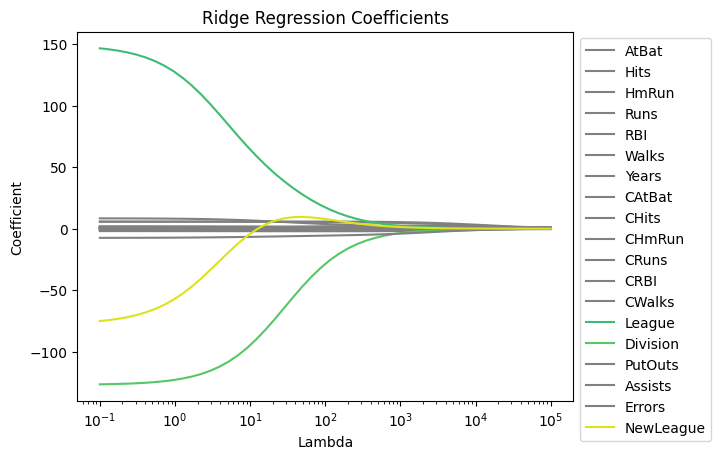

In [269]:
from sklearn.linear_model import Ridge

def plot_ridge_coeffs(X_train, X_test, y_train, y_test, lambdas, plot=0):
    """
    Fit a ridge regression model with different lambda values, plot the coefficients for each predictor,
    and determine the significance of each predictor based on the smallest lambda tested.

    Args:
    - X_train, X_test, y_train, y_test: Training and test sets. as pandas dataframes
    - lambdas: A list of lambda values to test.
    - predictors: A list of predictor variable names.
    - plot: An optional boolean indicating whether to plot the coefficients for each predictor, taken as 0 if not specified.

    Returns:
    - MSEs: A list of mean squared errors for each lambda value.
    """
    # Retrieve the predictor names
    predictors = X_train.columns.tolist()

    # Initialize an empty matrix to store the coefficients and MSE's
    coef_matrix = []
    MSEs = []

    # Fit the model for each lambda value and store the coefficients in the matrix
    for alpha in lambdas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        coef_matrix.append(ridge.coef_)
        # store the MSE for each lambda value
        mse = np.mean((ridge.predict(X_test) - y_test)**2)
        MSEs.append(mse)

    if plot ==1: 
        # Determine the significance of each predictor based on the smallest lambda tested
        significant = [abs(coef_matrix[0][i]) > 10 for i in range(len(predictors))]

        # Plot the coefficients for each predictor
        for i in range(len(predictors)):
            plt.plot(lambdas, [row[i] for row in coef_matrix], 
                 color='grey' if not significant[i] else plt.cm.viridis(1.*i/len(predictors)), 
                 label=predictors[i])
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        # Customize the plot
        plt.xscale('log') ,plt.xlabel('Lambda'), plt.ylabel('Coefficient'), plt.title('Ridge Regression Coefficients')
        plt.show()

    # return the MSE's
    return MSEs

# call the function 
MSEs = plot_ridge_coeffs(X_train, X_test, y_train, y_test, lambdas, plot=1)

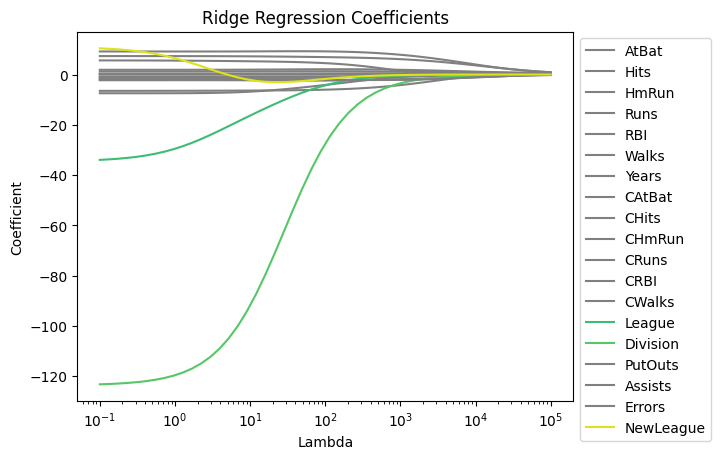

In [270]:
# switch the test and train sets for k=2 fold cross validation
MSEs2 = plot_ridge_coeffs(X_test, X_train, y_test, y_train, lambdas, plot=1)

The best lambda value is 21.209508879201906


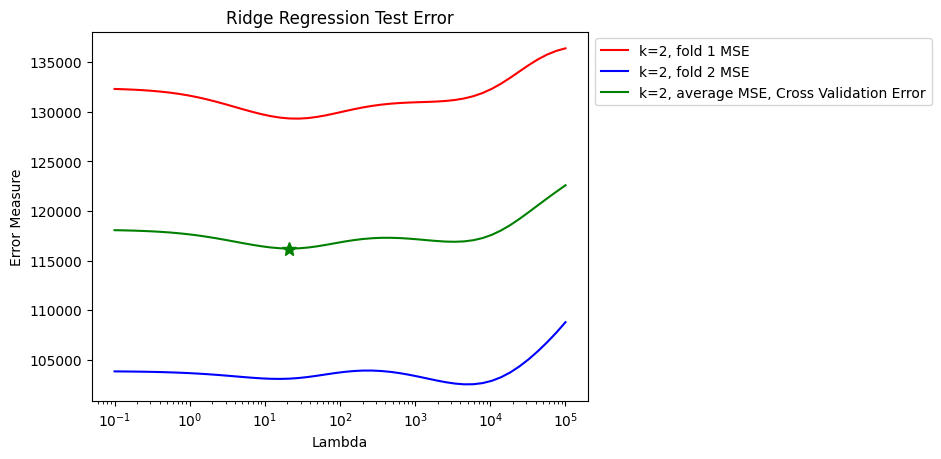

In [271]:
# plot the MSE for each lambda value
plt.plot(lambdas, MSEs, color='red')
plt.plot(lambdas, MSEs2, color='blue')
# the average of the two MSE's for each lambda value
plt.plot(lambdas, (np.array(MSEs)+np.array(MSEs2))/2, color='green')

# Customize the plot
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Error Measure')
plt.title('Ridge Regression Test Error')
# add a legend
plt.legend(['k=2, fold 1 MSE', 'k=2, fold 2 MSE', 'k=2, average MSE, Cross Validation Error'], loc='upper left', bbox_to_anchor=(1,1))

# Determine the best lambda value from the averaged mse 
best_lambda = lambdas[np.argmin((np.array(MSEs)+np.array(MSEs2))/2)]
print('The best lambda value is',best_lambda)
# plot the best lambda value as a star
plt.plot(best_lambda, np.min((np.array(MSEs)+np.array(MSEs2))/2), color='green', marker='*', markersize=10)

plt.show()


In [272]:
# the average MSE for the best lambda value
print('The average MSE for the best lambda value is',np.min((np.array(MSEs)+np.array(MSEs2))/2))
ridgeMSE = np.min((np.array(MSEs)+np.array(MSEs2))/2)

The average MSE for the best lambda value is 116206.16813984181


The Cross validation error is equal to the average test MSE among the folds

The MSE for the test set is 129318.51102468764


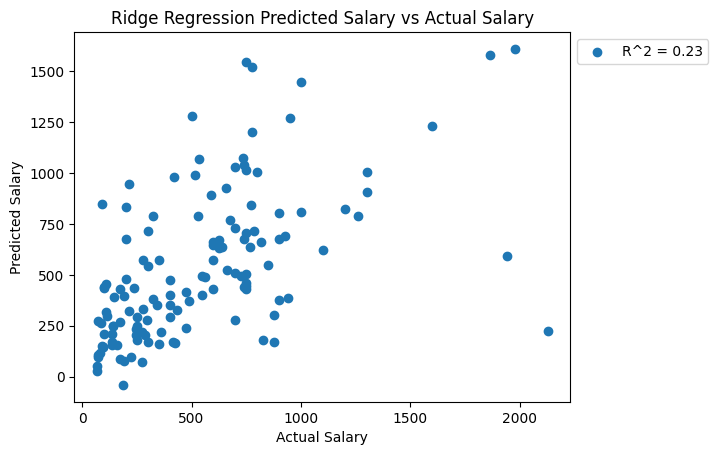

In [273]:
#refit the model using the best lambda value
ridge = Ridge(alpha=best_lambda)
ridge.fit(X_train, y_train)
# predict the salary for the test set
y_pred = ridge.predict(X_test)
# calculate the MSE
mse = np.mean((y_pred - y_test)**2)
print('The MSE for the test set is',mse)
# plot the predicted salary against the actual salary
plt.scatter(y_test, y_pred)

# add labels
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Ridge Regression Predicted Salary vs Actual Salary')
# add a legend with the R^2 value
plt.legend(['R^2 = '+str(round(ridge.score(X_test, y_test),2))], loc='upper left', bbox_to_anchor=(1,1))
plt.show()



In [274]:
# find the regular multiple regression model r^2
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)
print('The R^2 for the multiple regression model is',lm.score(X_test, y_test))

The R^2 for the multiple regression model is 0.21465589018164488


The ridge regression R^2 value is better than the single and multiple linear regression where the highest R^2 was 0.32

### (d) Fit a lasso model on the training set for a range of lamba values

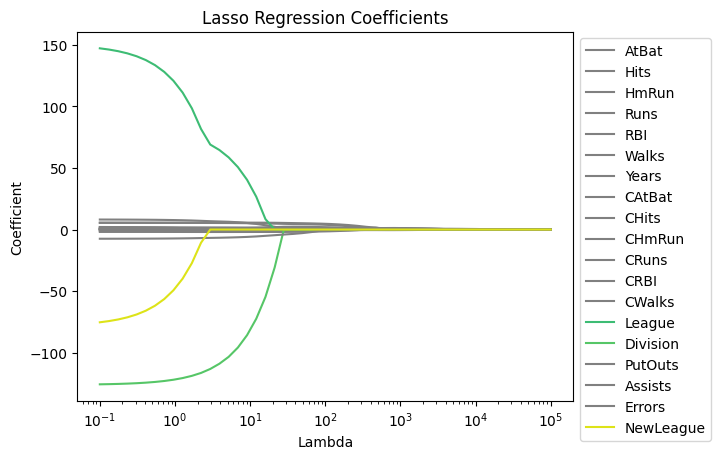

In [275]:
from sklearn.exceptions import ConvergenceWarning

def plot_lasso_coeffs(X_train, X_test, y_train, y_test, lambdas, plot=0):
    """
    Fit a lasso regression model with different lambda values, plot the coefficients for each predictor,
    and determine the significance of each predictor based on the smallest lambda tested.

    Args:
    - X_train, X_test, y_train, y_test: Training and test sets. as pandas dataframes
    - lambdas: A list of lambda values to test.
    - predictors: A list of predictor variable names.
    - plot: An optional boolean indicating whether to plot the coefficients for each predictor, taken as 0 if not specified.

    Returns:
    - MSEs: A list of mean squared errors for each lambda value.
    """
    # Retrieve the predictor names
    predictors = X_train.columns.tolist()

    # Initialize an empty matrix to store the coefficients and MSE's
    coef_matrix = []
    MSEs = []

    # Fit the model for each lambda value and store the coefficients in the matrix
    for alpha in lambdas:
        lasso = Lasso(alpha=alpha)
        try:
            lasso.fit(X_train, y_train)
        except ConvergenceWarning:
            print(f"Lasso with alpha={alpha} did not converge.")
            non_converging += 1
        coef_matrix.append(lasso.coef_)
        # store the MSE for each lambda value
        mse = np.mean((lasso.predict(X_test) - y_test)**2)
        MSEs.append(mse)

    if plot == 1: 
        # Determine the significance of each predictor based on the smallest lambda tested
        significant = [abs(coef_matrix[0][i]) > 10 for i in range(len(predictors))]

        # Plot the coefficients for each predictor
        for i in range(len(predictors)):
            plt.plot(lambdas, [row[i] for row in coef_matrix], 
                 color='grey' if not significant[i] else plt.cm.viridis(1.*i/len(predictors)), 
                 label=predictors[i])
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        # Customize the plot
        plt.xscale('log') ,plt.xlabel('Lambda'), plt.ylabel('Coefficient'), plt.title('Lasso Regression Coefficients')
        plt.show()

    # return the MSE's
    return MSEs

# call the function
MSEs = plot_lasso_coeffs(X_train, X_test, y_train, y_test, lambdas, plot=1)


In [276]:
# switch the test and train sets for k=2 fold cross validation
MSEs2 = plot_lasso_coeffs(X_test, X_train, y_test, y_train, lambdas)


The best lambda value is 12.067926406393289


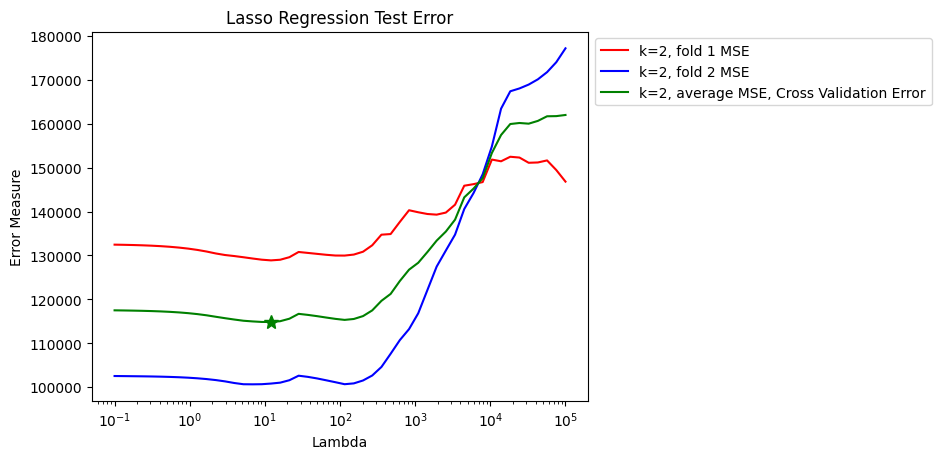

In [277]:
# plot the MSE for each lambda value
plt.plot(lambdas, MSEs, color='red')
plt.plot(lambdas, MSEs2, color='blue')
# the average of the two MSE's for each lambda value
plt.plot(lambdas, (np.array(MSEs)+np.array(MSEs2))/2, color='green')

# Customize the plot
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Error Measure')
plt.title('Lasso Regression Test Error')
# add a legend
plt.legend(['k=2, fold 1 MSE', 'k=2, fold 2 MSE', 'k=2, average MSE, Cross Validation Error'], loc='upper left', bbox_to_anchor=(1,1))

# Determine the best lambda value from the averaged mse 
best_lambda = lambdas[np.argmin((np.array(MSEs)+np.array(MSEs2))/2)]
print('The best lambda value is',best_lambda)
# plot the best lambda value as a star
plt.plot(best_lambda, np.min((np.array(MSEs)+np.array(MSEs2))/2), color='green', marker='*', markersize=10)

plt.show()

In [278]:
# the average MSE for the best lambda value
print('The average MSE for the best lambda value is',np.min((np.array(MSEs)+np.array(MSEs2))/2))
lassoMSE = np.min((np.array(MSEs)+np.array(MSEs2))/2)

The average MSE for the best lambda value is 114844.83352735217


The MSE for the test set is 128877.5887946392


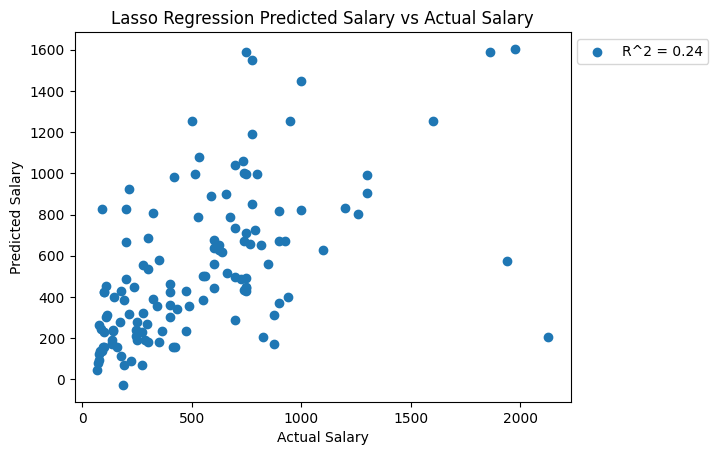

In [279]:
# refit the model using the best lambda value
lasso = Lasso(alpha=best_lambda)
lasso.fit(X_train, y_train)
# predict the salary for the test set
y_pred = lasso.predict(X_test)
# calculate the MSE
mse = np.mean((y_pred - y_test)**2)
print('The MSE for the test set is',mse)
# plot the predicted salary against the actual salary
plt.scatter(y_test, y_pred)
# find the r^2 value]
r2 = lasso.score(X_test, y_test)
# add labels
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Lasso Regression Predicted Salary vs Actual Salary')
# add a legend with the R^2 value
plt.legend(['R^2 = '+str(round(r2,2))], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


The Average MSE is again the cross validation error! The test errors are both very similar 

In [280]:
#The lower MSE ridge vs lasso
print('The MSE for the ridge regression model is',ridgeMSE)
print('The MSE for the lasso regression model is',lassoMSE)


The MSE for the ridge regression model is 116206.16813984181
The MSE for the lasso regression model is 114844.83352735217
